In [131]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
from tslearn.datasets import UCR_UEA_datasets
import sklearn
import pickle
import numpy as np 
import torch 
from TSInterpret_Artifacts.ClassificationModels.CNN_T import ResNetBaseline, UCRDataset, fit
import warnings
warnings.filterwarnings("ignore") 

from tslearn.preprocessing import TimeSeriesScalerMinMax
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

from tslearn.shapelets import LearningShapelets

In [98]:
# Plot single Time Series with Label
def plot_ts(ts_sample):
    ts= ts_sample
    plt.figure(figsize=(10, 4))
    plt.plot(ts, label="Time Series", color='blue')
    plt.title(f"Time Series")
    plt.xlabel("Time Steps")
    plt.ylabel("Value")

    # Display grid and legend
    plt.grid(False)
    # plt.legend()
    plt.show()


def scale_dataset(traindata, testdata):
    minmaxscaler = MinMaxScaler()
    minmaxscaler.fit(traindata.reshape(-1, 1))

    scaled_traindata = minmaxscaler.transform(traindata.reshape(-1, 1)).reshape(-1, traindata.shape[1], 1)
    scaled_testdata = minmaxscaler.transform(testdata.reshape(-1, 1)).reshape(-1, traindata.shape[1], 1)
    return scaled_traindata, scaled_testdata

In [135]:
dataset='Coffee'
train_x,train_y, test_x, test_y=UCR_UEA_datasets().load_dataset(dataset)


In [16]:
from pyts.datasets import fetch_ucr_dataset
train_x, test_x, train_y, test_y = fetch_ucr_dataset("GunPoint", return_X_y = True)

train_x = train_x.reshape(-1, train_x.shape[1], 1)
test_x = test_x.reshape(-1, train_x.shape[1], 1)


In [17]:
train_x.shape

(50, 150, 1)

In [136]:
train_x_scaled, test_x_scaled = scale_dataset(train_x, test_x)

In [ ]:
model = LearningShapelets(n_shapelets_per_size={30: 4})
model.fit(train_x_scaled, train_y)
train_distances = model.transform(train_x_scaled)
test_distances = model.transform(test_x_scaled)
shapelets = model.shapelets_

In [25]:
distances = model.transform(train_x) # Transforms each TS sample into space formed by the distances to each shapelet
predicted_locations = model.locate(train_x)

In [26]:
shap = model.shapelets_[0]
shap = TimeSeriesScalerMinMax().fit_transform(shap.reshape(1, -1, 1)).flatten()

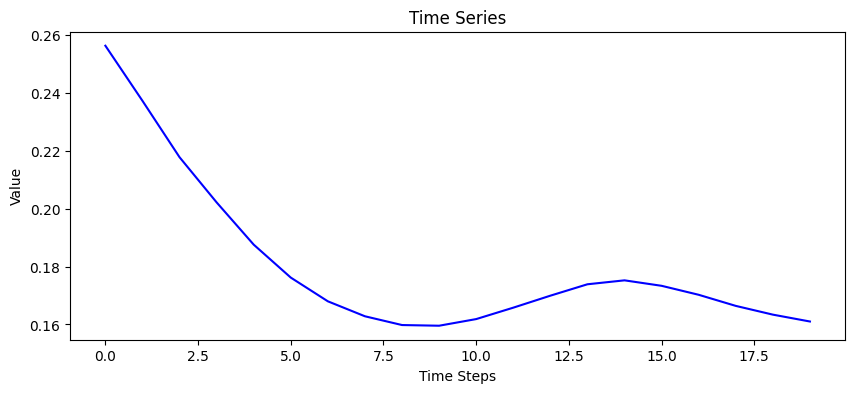

In [27]:
plot_ts(shapelets[0])

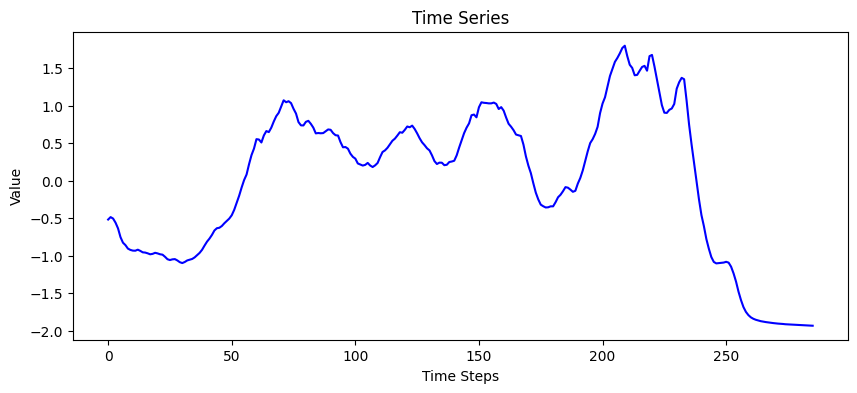

In [28]:
plot_ts(train_x[0])

In [138]:
distances = model.transform(test_x_scaled)

In [139]:
distances_with_label = []
for i in range(len(distances)):
    distances_with_label.append([distances[i], test_y[i]])

In [120]:
len(distances_with_label)

150

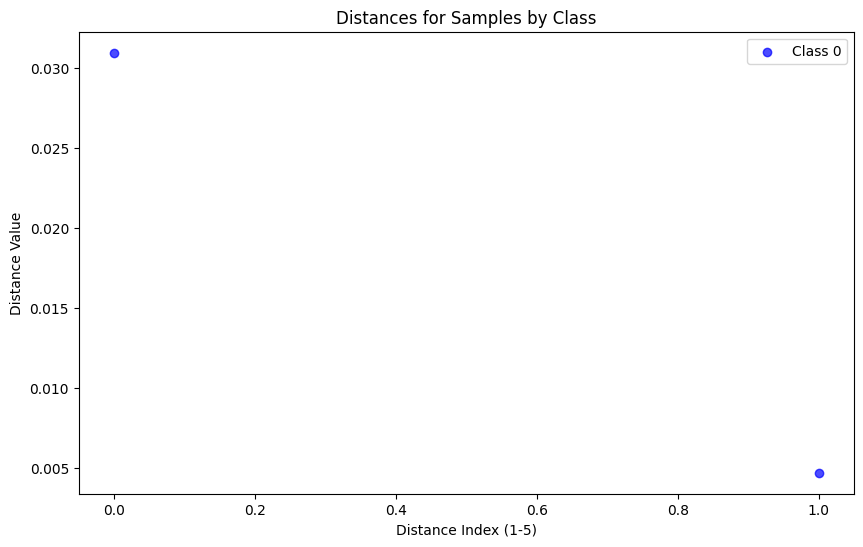

In [ ]:
# Prepare data for plotting
x = np.arange(0, 2)  # x-axis (1 to 5 for distances)
class_0_distances = [sample[0] for sample in distances_with_label if sample[1] == 2]
class_1_distances = [sample[0] for sample in distances_with_label if sample[1] == 1]

# Plot the data
plt.figure(figsize=(10, 6))

# Plot class 0
for distances in class_0_distances:
    plt.scatter(x, distances, color='blue', alpha=0.7, label='Class 0')

# Plot class 1
for distances in class_1_distances:
    plt.scatter(x, distances, color='orange', alpha=0.7, label='Class 1')

# Add legend
# Prevent duplicate legend entries
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys())

# Customize plot
plt.title("Distances for Samples by Class")
plt.xlabel("Distance Index (1-5)")
plt.ylabel("Distance Value")

# Show plot
plt.show()

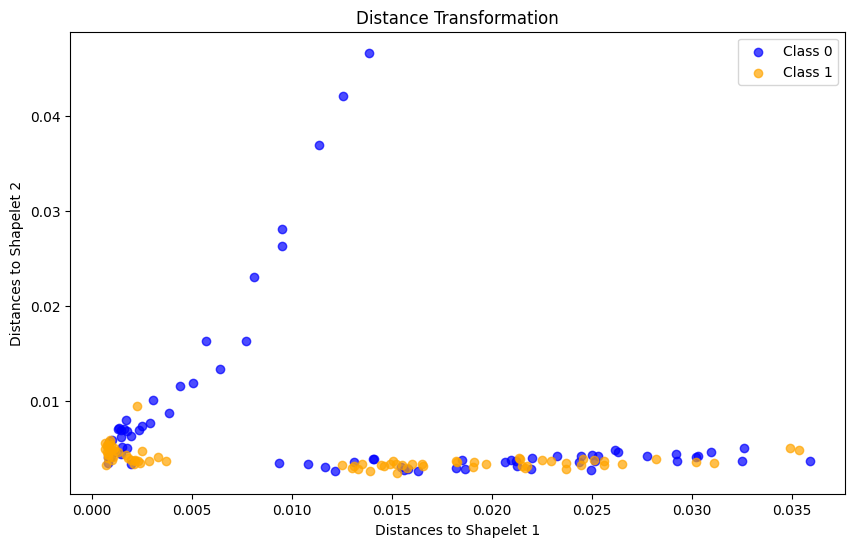

In [134]:
# Prepare data for plotting
x = np.arange(0, 2)  # x-axis (1 to 5 for distances)
class_0_distances = [sample[0] for sample in distances_with_label if sample[1] == 2]
class_1_distances = [sample[0] for sample in distances_with_label if sample[1] == 1]

# Plot the data
plt.figure(figsize=(10, 6))

# Plot class 0
for distances in class_0_distances:
    plt.scatter(distances[0], distances[1], color='blue', alpha=0.7, label='Class 0')

# Plot class 1
for distances in class_1_distances:
    plt.scatter(distances[0], distances[1], color='orange', alpha=0.7, label='Class 1')

# Add legend
# Prevent duplicate legend entries
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys())

# Customize plot
plt.title("Distance Transformation")
plt.xlabel("Distances to Shapelet 1")
plt.ylabel("Distances to Shapelet 2")

# Show plot
plt.show()

In [39]:
model.shapelets_

array([array([[0.25632283],
              [0.23728265],
              [0.21779284],
              [0.20218001],
              [0.1875824 ],
              [0.17619334],
              [0.16799416],
              [0.16282555],
              [0.15979724],
              [0.15956219],
              [0.16185766],
              [0.16580091],
              [0.16994327],
              [0.17388532],
              [0.17524342],
              [0.17335476],
              [0.17025167],
              [0.16641758],
              [0.16339388],
              [0.16101922]]), array([[0.6232295 ],
                                     [0.61972392],
                                     [0.61882788],
                                     [0.61957335],
                                     [0.62644696],
                                     [0.63662696],
                                     [0.64256501],
                                     [0.6363318 ],
                                     [0.62965351],
         

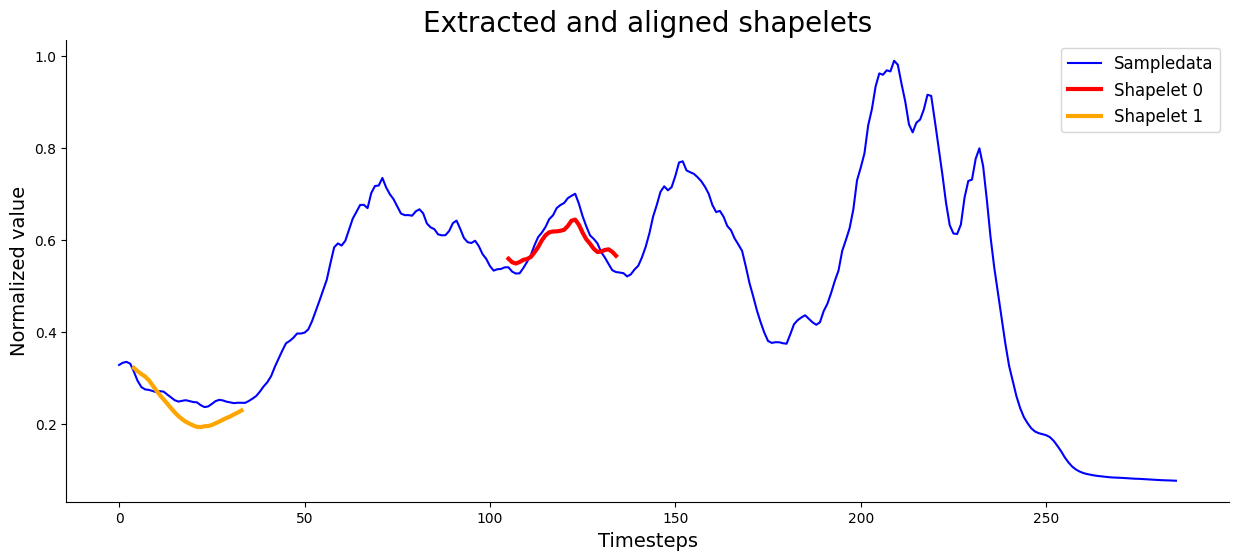

In [152]:
# 0 - 13 Label 0; 14 - 27 Label 1

distances = model.transform(train_x_scaled) # Do not use since distances come from blackbox model and are not the same as manually calculated distances
predicted_locations = model.locate(train_x_scaled)

fig, ax = plt.subplots(figsize=(15, 6))

# Plot the shapelet and align it on the best matched time series. The optimizer
# will often enlarge the shapelet to create a larger gap between the distances
# of both classes. We therefore normalize the shapelet again before plotting.

test_ts_id = 10 #np.argmin(np.sum(distances, axis=1))
id_shap = 0

colors = ["red", "orange", "green", "black", "purple"]

ax.plot(train_x_scaled[test_ts_id].ravel(), color='blue', label="Sampledata")
for id_shap in range(len(model.shapelets_)):
    shap = model.shapelets_[id_shap]
    #shap = TimeSeriesScalerMinMax().fit_transform(shap.reshape(1, -1, 1)).flatten()
    pos = predicted_locations[test_ts_id, id_shap]
    ax.plot(np.arange(pos, pos + len(shap)), shap, linewidth=3, color=colors[id_shap], label=f"Shapelet {id_shap}")
    # ax.axvline(pos, color='k', linestyle='--', alpha=0.25)

ax.set_ylabel("Normalized value", fontdict={'fontsize' : 14})
ax.set_xlabel("Timesteps", fontdict={'fontsize' : 14})
ax.set_title("Extracted and aligned shapelets", fontdict = {'fontsize' : 20})
ax.spines[['right', 'top']].set_visible(False)
ax.legend(prop={'size': 12})

In [118]:
len(test_dataset)

150

batchsize kleiner

shapelet länge kürzer (evtl mischen)

bei evaluation bereiche, die gecancelt werden, sampleweise festlegen, da shapelets unterschiedliche Positionen je Sample haben können

1. Sampleweise Evaluationsbereiche festlegen
    
    a. Shapelets: Manuell definiert durch Anzahl (n) und Länge (l) der Shapelets
    
    b. Grad-Cam: bestimme n Bereiche der Länge l wie folgt: starte mit threshold von 1; senke ihn so lange ab, bis ein Bereich die Länge l erreicht; fahre fort, bis n Bereiche erhalten sind


2. Gefundene Bereiche auscanceln (evtl. inkl. einer Margin?)


3. Unterschiede in der verlorenen Klassifikationskonfidenz für Fälle a. und b. vergleichen



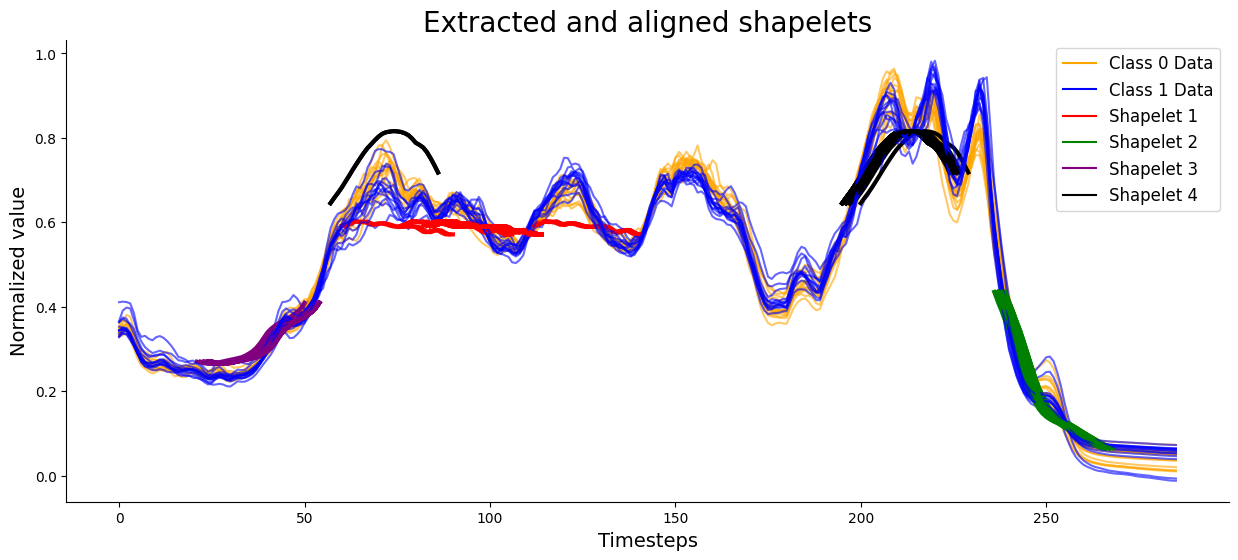

In [156]:
test_dataset = UCRDataset(test_x_scaled.astype(np.float32),test_y.astype(np.float32))
predicted_locations = model.locate(test_x_scaled)

time_axis = np.arange(train_x.shape[1])
fig, ax = plt.subplots(figsize=(15, 6))

colors = ["red", "green", "purple", "black", "yellow"]

for test_ts_id in range(len(test_dataset)):
    input_tensor = test_dataset[test_ts_id][0]
    label = test_dataset[test_ts_id][1]

    # Visualization
    color = 'blue' if label == 1 else 'orange'
    ax.plot(time_axis, input_tensor, label="Input Time Series", color=color, alpha=0.6)

    for id_shap in range(len(model.shapelets_)):
        shap = model.shapelets_[id_shap]
        #shap = TimeSeriesScalerMinMax().fit_transform(shap.reshape(1, -1, 1)).flatten()
        pos = predicted_locations[test_ts_id, id_shap]
        ax.plot(np.arange(pos, pos + len(shap)), shap, linewidth=3, color=colors[id_shap])

ax.set_ylabel("Normalized value", fontdict={'fontsize' : 14})
ax.set_xlabel("Timesteps", fontdict={'fontsize' : 14})
ax.set_title("Extracted and aligned shapelets", fontdict = {'fontsize' : 20})
ax.spines[['right', 'top']].set_visible(False)

colors = ['orange', 'blue', 'red', 'green', 'purple', 'black']
lines = [Line2D([0], [0], color=c) for c in colors]
labels = ['Class 0 Data', 'Class 1 Data', 'Shapelet 1', 'Shapelet 2', 'Shapelet 3', 'Shapelet 4']
plt.legend(lines, labels, prop={'size': 12})



In [112]:
predicted_locations.shape

(50, 2)

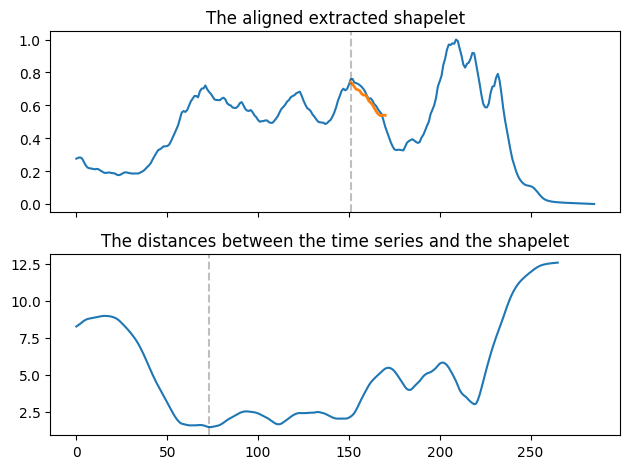

In [15]:
# 0 - 13 Label 0; 14 - 27 Label 1

distances = model.transform(train_x_scaled) # Do not use since distances come from blackbox model and are not the same as manually calculated distances
predicted_locations = model.locate(train_x_scaled)

f, ax = plt.subplots(2, 1, sharex=True)

# Plot the shapelet and align it on the best matched time series. The optimizer
# will often enlarge the shapelet to create a larger gap between the distances
# of both classes. We therefore normalize the shapelet again before plotting.

test_ts_id = 10 #np.argmin(np.sum(distances, axis=1))
id_shap = 1

shap = model.shapelets_[id_shap]
#shap = TimeSeriesScalerMinMax().fit_transform(shap.reshape(1, -1, 1)).flatten()
pos = predicted_locations[test_ts_id, id_shap]
ax[0].plot(train_x_scaled[test_ts_id].ravel())
ax[0].plot(np.arange(pos, pos + len(shap)), shap, linewidth=2)
ax[0].axvline(pos, color='k', linestyle='--', alpha=0.25)
ax[0].set_title("The aligned extracted shapelet")

# We calculate the distances from the shapelet to the timeseries ourselves.
distances_man = []
time_series = train_x_scaled[test_ts_id].ravel()
for i in range(len(time_series) - len(shap)):
    distances_man.append(np.linalg.norm(time_series[i:i+len(shap)] - shap)) # Dynamic Time Warping als Distanzmetrik
ax[1].plot(distances_man)
ax[1].axvline(np.argmin(distances_man), color='k', linestyle='--', alpha=0.25)
ax[1].set_title('The distances between the time series and the shapelet')

plt.tight_layout()
plt.show()

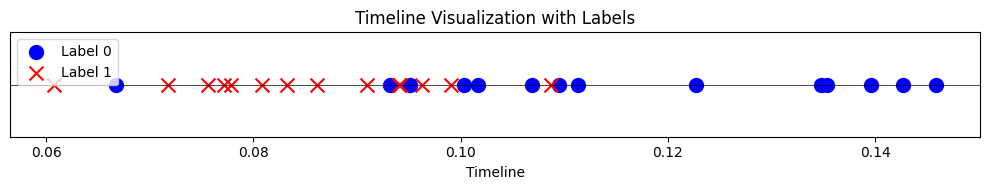

In [56]:
data = train_distances.flatten()
labels = train_y

# Marker styles for labels
marker_styles = {0: 'o', 1: 'x'}
colors = {0: 'blue', 1: 'red'}

# Create the figure and axis
plt.figure(figsize=(10, 2))
plt.axhline(0, color='black', linewidth=0.5)  # Timeline baseline

# Plot points on the timeline
for dist, label in zip(data, labels):
    plt.scatter(dist, 0, marker=marker_styles[label], color=colors[label], s=100, label=f'Label {label}')

# Remove duplicate legend entries
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys(), loc='upper left')

# Add annotations for each point
# for number in data:
#     plt.text(number, 0.1, str(number), ha='center', va='bottom', fontsize=9)

# Adjust timeline aesthetics
plt.yticks([])  # Remove y-axis ticks
plt.xlabel('Timeline')
plt.title('Timeline Visualization with Labels')
plt.tight_layout()
plt.show()

In [55]:
np.argmin(distances_man)

85

In [44]:
distances[85]

10.93835248102729

In [49]:
distances[88:][79]

11.289543607112282

In [53]:
distances_man[167]

11.289543607112282